# Building and Testing Local Corrective RAG

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

We will implement this agent as a custom / user-defined control flow in LangGraph. 

Then, we will show how to test these agents. 

(1) We'll use an [evaluation set of question-answer pairs for RAG in LangSmith](https://docs.smith.langchain.com/tutorials/Developers/agents#eval). 

(2) We'll evaluate end-to-end performance of our agents along with the specific reasoning trace of each one.

This notebook will reference ideas from [these slides](https://docs.google.com/presentation/d/1QWkXi4DYjfw94eHcy9RMLqpQdJtS2C_kx_u7wAUvlZE/edit?usp=sharing).



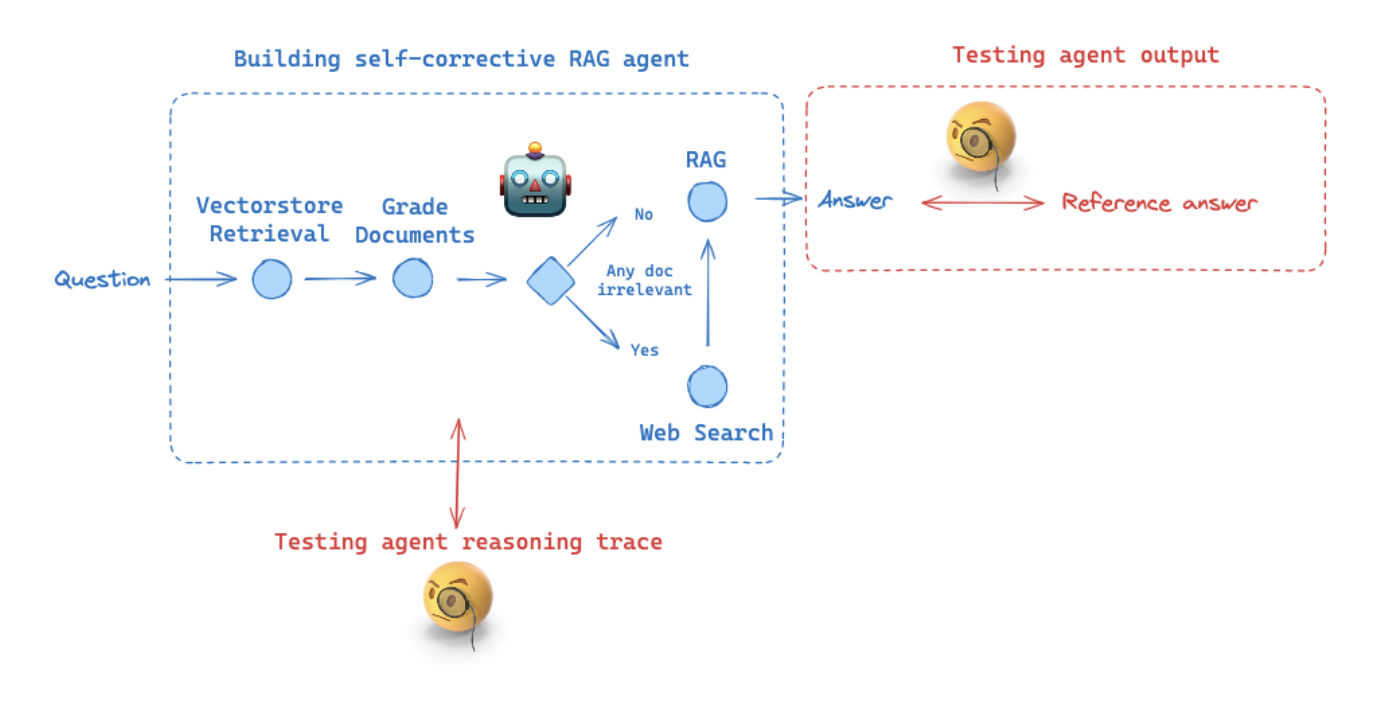

## Environment

We'll use [llama3.1 with Ollama](https://ai.meta.com/blog/meta-llama-3-1/) as our LLM, but this can be easily swapped. 

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [OpenAI embeddings](https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/#embed-documents), but this can be swapped for Nomic local embeddings.

We'll use [LangSmith](https://docs.smith.langchain.com/) for tracing and evaluation.

In [ ]:
%%capture --no-stderr
%pip install -U langchain tavily-python langgraph matplotlib langchain_community langchain-openai scikit-learn langchainhub langchain-ollama nomic[local]

## Custom LangGraph Agent

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using NomicEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    # embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [3]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

rag_chain = prompt | llm | StrOutputParser()

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(model="llama3.1", format="json", temperature=0)


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

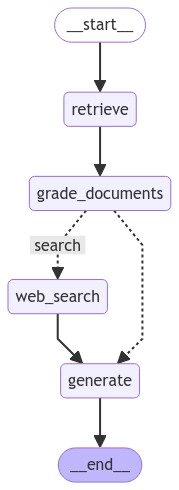

In [5]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, retrieve)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
import uuid


def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
# response = predict_custom_agent_answer(example)
# response

## Evaluation

Now we've defined two different agent architectures that do roughly the same thing!

We can evaluate them. See our [conceptual guide](https://docs.smith.langchain.com/concepts/evaluation#agents) for context on agent evaluation.

### Response

First, we can assess how well [our agent performs on a set of question-answer pairs](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation).

We'll use a dataset, `"Corrective RAG Agent Testing`.


In [ ]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `gpt-4o` as our LLM grader.

In [7]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [8]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [ ]:
from langsmith.evaluation import evaluate

dataset_name = "Corrective RAG Agent Testing"
model_tested = "llama3.1"
metadata = "CRAG, llama3.1"
experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,
    metadata={"version": metadata},
)

Dataset - 

https://smith.langchain.com/public/6c6c4543-1e56-4126-ab18-a84a31ff4946/d

Results -

* Latency for llama3.1 appears higher than llama3.
* Compares well to other, larger llms and beat llama3.

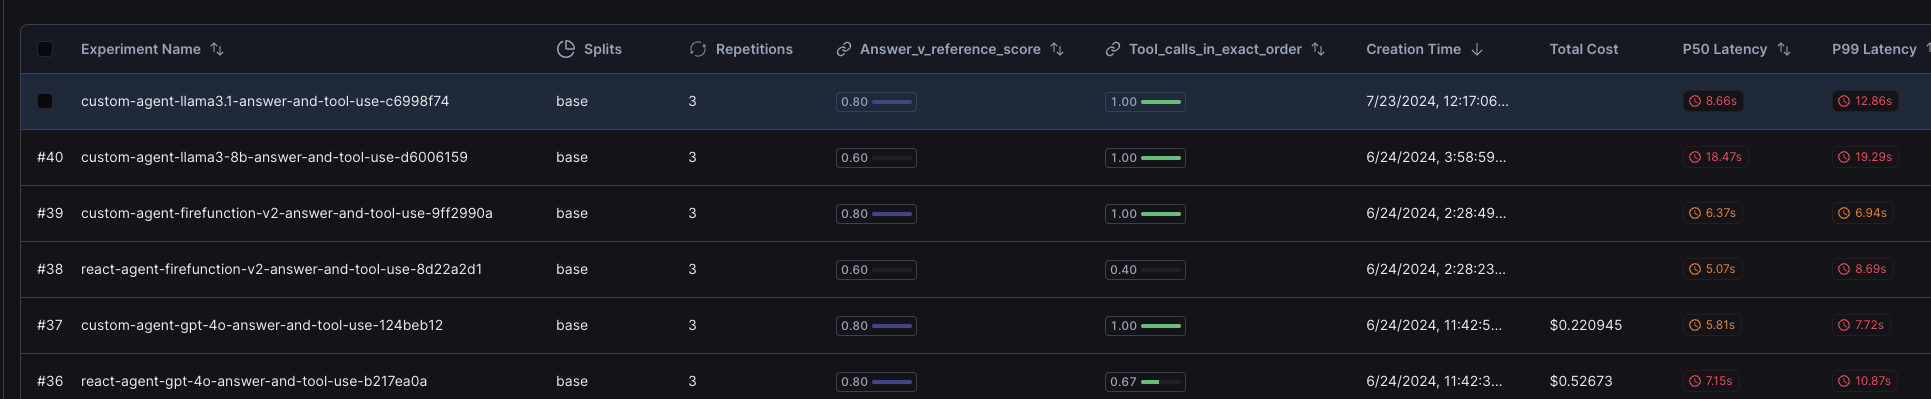